##**Introduction:**
Here, we’re working with the [SMS Spam Collection dataset from UCI](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) to automate chat analysis using NLP. The goal is to extract key points, identify sentiments, and classify intentions from chat data, helping organizations gain actionable insights from large volumes of text. This includes tasks like spam detection, topic modeling, and summarization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Load the dataset with the delimiter
df = pd.read_csv('/content/SMSSpamCollection.csv', delimiter='\t', header=None, names=['label', 'message'])

#Display the first few rows
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
#Count the number of spam and ham messages
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
#Check for missing values
print(df.isnull().sum())

#Check for any duplicate rows
print(df.duplicated().sum())

#Drop duplicates (if any)
df = df.drop_duplicates()

#Check the first few rows to ensure it's clean
print(df.head())

label      0
message    0
dtype: int64
0
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
#Add a column for word count
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

#Display basic statistics for word count
print(df['word_count'].describe())

count    5169.000000
mean       15.439930
std        11.117073
min         1.000000
25%         7.000000
50%        12.000000
75%        22.000000
max       171.000000
Name: word_count, dtype: float64


Exploratory Data Analysis (EDA)

<ipython-input-55-e25cedcbe9bb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


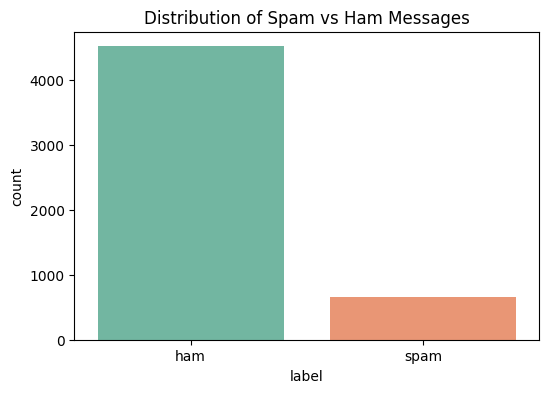

In [ ]:
#Plot the distribution of labels (Spam vs Ham)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

The graph shows there are many more legitimate (ham) messages than spam messages in the dataset - about 6-7 times more ham than spam. This big difference in numbers is normal in real chat systems but can make it tricky for spam detection models to work their best.

<ipython-input-56-d3871d6a5ae6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette='Set2')


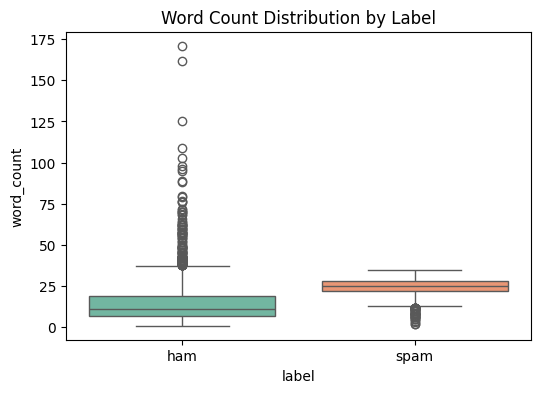

In [ ]:
#Plot word count distribution by label (Spam vs Ham)
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='word_count', data=df, palette='Set2')
plt.title('Word Count Distribution by Label')
plt.show()

The graph shows that spam messages tend to be more consistent in length, while legitimate messages vary more in length, with some being very long. This makes sense since real messages serve different purposes requiring different lengths.

**Text Preprocessing:**

1. Lowercase all the text.
2. Remove punctuation.
3. Remove stopwords.
4. Tokenize the messages.

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')

#Function to preprocess messages
def preprocess_message(message):
    #Convert to lowercase
    message = message.lower()

    #Remove punctuation
    message = message.translate(str.maketrans('', '', string.punctuation))

    #Tokenize the message
    words = word_tokenize(message)

    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

#Apply preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_message)

#Check the first few rows of the processed data
print(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  label                                            message  word_count  \
0   ham  Go until jurong point, crazy.. Available only ...          20   
1   ham                      Ok lar... Joking wif u oni...           6   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          28   
3   ham  U dun say so early hor... U c already then say...          11   
4   ham  Nah I don't think he goes to usf, he lives aro...          13   

                                   processed_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


Top Words in Spam and Ham Messages


In [ ]:
from collections import Counter

#Function to get top words
def get_top_words(texts):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(10)

#Get top words for spam and ham messages separately
spam_messages = df[df['label'] == 'spam']['processed_message']
ham_messages = df[df['label'] == 'ham']['processed_message']

top_spam_words = get_top_words(spam_messages)
top_ham_words = get_top_words(ham_messages)

print("Top words in spam messages:", top_spam_words)
print("Top words in ham messages:", top_ham_words)

Top words in spam messages: [('call', 303), ('free', 188), ('2', 155), ('txt', 126), ('u', 124), ('ur', 119), ('mobile', 105), ('stop', 105), ('text', 103), ('4', 97)]
Top words in ham messages: [('u', 891), ('im', 436), ('get', 295), ('2', 292), ('ltgt', 254), ('dont', 248), ('ok', 247), ('go', 242), ('got', 238), ('like', 221)]


###**Feature Engineering:**
TF-IDF (Term Frequency-Inverse Document Frequency):
This will convert the processed text data into a matrix of features, where each feature represents the importance of a word in the document compared to its frequency across all documents.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  #Limiting to 5000 features to avoid overfitting

#Fit and transform the processed messages
X = tfidf_vectorizer.fit_transform(df['processed_message']).toarray()

#Check the shape of the TF-IDF matrix
print(X.shape)

(5169, 5000)


**Label Encoding:**

We need to encode the labels ("ham" and "spam") into numerical values, where:

"ham" = 0
"spam" = 1

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Initialize a label encoder
label_encoder = LabelEncoder()

#Encode the labels (ham = 0, spam = 1)
y = label_encoder.fit_transform(df['label'])

#Check the encoded labels
print(y[:5])

[0 0 1 0 0]


Splitting the data:

In [ ]:
from sklearn.model_selection import train_test_split

#Split the data into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Check the size of the training and testing sets
print(X_train.shape, X_test.shape)

(4135, 5000) (1034, 5000)


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

#Train the model on the training data
model.fit(X_train, y_train)

#Make predictions on the test data
y_pred = model.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

#Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.9506769825918762
Confusion Matrix:
[[890   4]
 [ 47  93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       894
           1       0.96      0.66      0.78       140

    accuracy                           0.95      1034
   macro avg       0.95      0.83      0.88      1034
weighted avg       0.95      0.95      0.95      1034



Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

#Train the model on the training data
nb_model.fit(X_train, y_train)

#Make predictions on the test data
y_pred_nb = nb_model.predict(X_test)

#Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)

#Print the evaluation metrics
print(f"Accuracy: {accuracy_nb}")
print(f"Confusion Matrix:\n{conf_matrix_nb}")
print(f"Classification Report:\n{class_report_nb}")

Accuracy: 0.97678916827853
Confusion Matrix:
[[894   0]
 [ 24 116]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       894
           1       1.00      0.83      0.91       140

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.95      1034
weighted avg       0.98      0.98      0.98      1034



Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#Train the model on the training data
rf_model.fit(X_train, y_train)

#Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

#Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

#Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print(f"Confusion Matrix:\n{conf_matrix_rf}")
print(f"Classification Report:\n{class_report_rf}")

Accuracy: 0.97678916827853
Confusion Matrix:
[[894   0]
 [ 24 116]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       894
           1       1.00      0.83      0.91       140

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.95      1034
weighted avg       0.98      0.98      0.98      1034



Here, both Naive Bayes and Random Forest performed identically and better than Logistic Regression.
####But we will choose Random Forest for hyperparameter tuning because it generally has higher potential for improvement through tuning compared to Naive Bayes, which has fewer parameters to adjust.
Random Forests are also generally more robust against overfitting than both Logistic Regression and Naive Bayes, especially with proper tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

#Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

#Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

#Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

#Use the best model from GridSearchCV to make predictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

#Evaluate the tuned model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
class_report_best_rf = classification_report(y_test, y_pred_best_rf)

#Print the evaluation metrics for the tuned model
print(f"Accuracy: {accuracy_best_rf}")
print(f"Confusion Matrix:\n{conf_matrix_best_rf}")
print(f"Classification Report:\n{class_report_best_rf}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
244 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.9738814993954051
Accuracy: 0.97678916827853
Confusion Matrix:
[[894   0]
 [ 24 116]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       894
           1       1.00      0.83      0.91       140

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.95      1034
weighted avg       0.98      0.98      0.98      1034



Interestingly, the overall metrics remained exactly the same after hyperparameter tuning. This suggests a possibility that the default parameters were already well-suited for this specific problem.